In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(1) #for reproducibility

In [3]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

print(train_dataset.data.size())
print(train_dataset.targets.size())

fig, axes = plt.subplots(1,4, figsize=(8,1.2), dpi=180)
for i in range(4):
    axes[i].imshow(train_dataset.data[i].numpy(), cmap='gray')
    axes[i].set_title(f"Target Label: {train_dataset.targets[i]}")
    axes[i].axis('off')
plt.show()


Failed to download (trying next):
HTTP Error 403: Forbidden



77.5%


RuntimeError: File not found or corrupted.

In [7]:
# Define the Autoencoder model
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=128),
            nn.Tanh(),          # (e^x - e^(-x)) / (e^x + e^(-x))
            nn.Linear(in_features=128, out_features=64),
            nn.Tanh(),
            nn.Linear(in_features=64, out_features=12),
            nn.Tanh(),
            nn.Linear(12, 3)    # compress to 3 features which can be visualized in plt
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()        # compress to a range(0, 1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Training loop
def train_autoencoder(autoencoder, train_loader, loss_function, optimizer, epochs, device):
    """
    Train the autoencoder model.

    Args:
        autoencoder: The autoencoder model to train.
        train_loader: DataLoader for the training data.
        loss_function: Loss function to minimize (e.g., nn.MSELoss()).
        optimizer: Optimizer for updating model weights.
        epochs: Number of epochs to train.
        device: Device to perform computation (e.g., 'cuda' or 'cpu').

    Returns:
        None
    """
    for epoch in range(epochs):
        for step, (x, y) in enumerate(train_loader):
            # Flatten input images and move to the device
            #b_x = x.view(-1, 28*28).to(device).requires_grad_(True)  # Input batch
            #b_y = b_x.clone()  # Target batch is the same as input
            b_x = x.view(-1, 28*28).requires_grad_(True)    # batch x, shape=(batch, 28*28)
            b_x = b_x.to(device)
            b_y = x.view(-1, 28*28).requires_grad_(True)    # batch y, shape=(batch, 28*28)
            b_y = b_y.to(device)


            # Forward pass
            encoded, decoded = autoencoder(b_x)

            # Compute loss
            loss = loss_function(decoded, b_y)

            # Backward pass and optimization
            optimizer.zero_grad()   # Clear gradients
            loss.backward()         # Compute gradients
            optimizer.step()        # Update model parameters

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
    
def test_autoencoder(autoencoder, test_loader, loss_function, device):
    """
    Test the autoencoder model.

    Args:
        autoencoder: The trained autoencoder model.
        test_loader: DataLoader for the test data.
        loss_function: Loss function to evaluate the reconstruction error.
        device: Device to perform computation (e.g., 'cuda' or 'cpu').

    Returns:
        avg_loss: Average reconstruction loss over the test dataset.
    """
    autoencoder.eval()  # Set the model to evaluation mode
    test_loss = 0.0

    with torch.no_grad():  # Disable gradient computation
        for step, (x, y) in enumerate(test_loader):
            # Flatten input images and move to the device
            b_x = x.view(-1, 28*28).to(device)  # Input batch
            b_y = b_x.clone()  # Target batch is the same as input

            # Forward pass
            _, decoded = autoencoder(b_x)

            # Compute loss
            loss = loss_function(decoded, b_y)
            test_loss += loss.item()

    avg_loss = test_loss / len(test_loader.dataset)
    print(f"Average Test Loss: {avg_loss:.4f}")
    return avg_loss

def visualize_reconstruction(autoencoder, test_loader, device, num_images=10):
    """
    Visualize original and reconstructed images.

    Args:
        autoencoder: The trained autoencoder model.
        test_loader: DataLoader for the test data.
        device: Device to perform computation (e.g., 'cuda' or 'cpu').
        num_images: Number of images to visualize.

    Returns:
        None
    """
    autoencoder.eval()  # Set the model to evaluation mode
    images_shown = 0

    with torch.no_grad():
        for step, (x, _) in enumerate(test_loader):
            x = x.to(device)
            b_x = x.view(-1, 28*28)  # Flatten the input images
            
            # Forward pass
            _, decoded = autoencoder(b_x)
            decoded = decoded.view(-1, 1, 28, 28).cpu()  # Reshape to image dimensions
            
            # Plot the images
            fig, axes = plt.subplots(2, num_images, figsize=(15, 4))
            for i in range(num_images):
                if images_shown >= num_images:
                    break

                # Original Image
                axes[0, i].imshow(x[i].cpu().squeeze(), cmap="gray")
                axes[0, i].set_title("Original")
                axes[0, i].axis("off")

                # Reconstructed Image
                axes[1, i].imshow(decoded[i].squeeze(), cmap="gray")
                axes[1, i].set_title("Reconstructed")
                axes[1, i].axis("off")

                images_shown += 1

            plt.tight_layout()
            plt.show()
            
            if images_shown >= num_images:
                break





Epoch: 0 | Step: 0  | Train Loss: 0.23


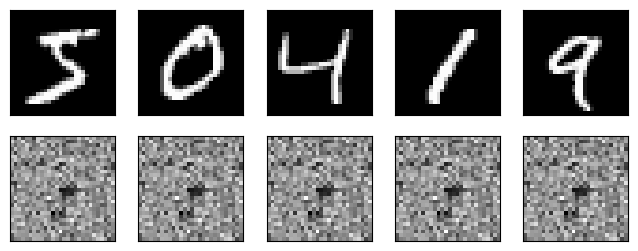


Epoch: 0 | Step: 500  | Train Loss: 0.11


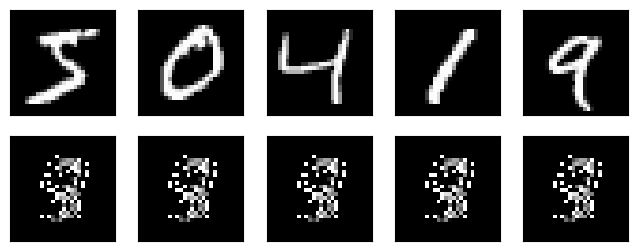


Epoch: 5 | Step: 0  | Train Loss: 0.11


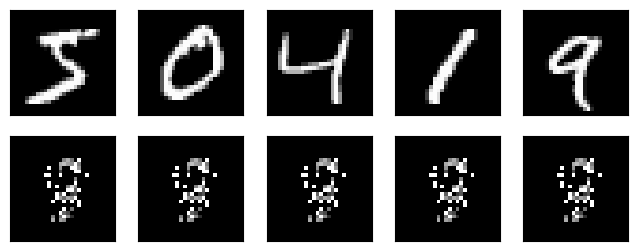


Epoch: 5 | Step: 500  | Train Loss: 0.11


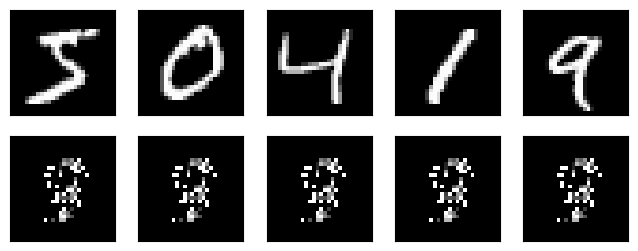


Epoch: 9 | Step: 0  | Train Loss: 0.11


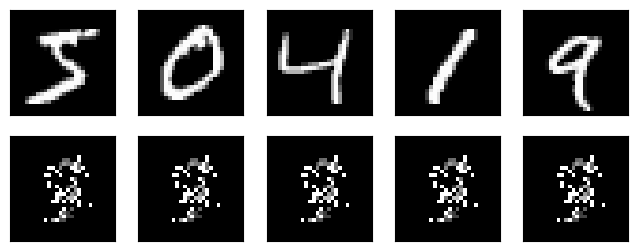


Epoch: 9 | Step: 500  | Train Loss: 0.12


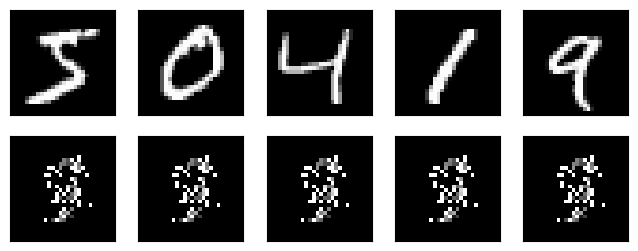

In [8]:
EPOCH = 10
BATCH_SIZE = 64
NUMBER_OF_TEST_IMAGE = 5
loss_function = nn.MSELoss()

autoencoder = AutoEncoder().to(device)  # Move the model to the specified device (e.g., 'cuda' or 'cpu')

# Define the optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.05)


# Define DataLoader parameters
BATCH_SIZE = 64


train_loader = DataLoader(dataset=train_dataset,
                               batch_size=BATCH_SIZE,
                               shuffle=True)

# original data (first row) for viewing
view_original_data = train_dataset.data[ : NUMBER_OF_TEST_IMAGE].view(-1, 28*28).type(torch.FloatTensor)/255.
view_original_data.requires_grad = True
view_original_data = view_original_data.to(device)

for epoch in range(EPOCH):  # 10 epochs
    for step, (x, y) in enumerate(train_loader):
        b_x = x.view(-1, 28*28).requires_grad_(True)    # batch x, shape=(batch, 28*28)
        b_x = b_x.to(device)
        """

        'b_y' viz. 'batch_y', considering 'INPUT_IMAGE (pixel values)' itself as our TRUTH VALUES,
        we will pass 'b_y' to loss_function, in order to minimize error between...
        'DECODED IMAGE PIXEL VALUES' and 'TARGET IMAGE PIXEL VALUES'.

        """
        b_y = x.view(-1, 28*28).requires_grad_(True)    # batch y, shape=(batch, 28*28)
        b_y = b_y.to(device)

        # passing b_x to the created instance of our model
        encoded, decoded = autoencoder(b_x)

        # passing decoded image and TARGET IMAGE to loss function
        loss = loss_function(decoded, b_y)  # MSELoss() function

        optimizer.zero_grad()   # clear gradients for this training step
        loss.backward()         # perform back-propagation
        optimizer.step()        # apply gradients

        """

        show original and decoded image after 500 steps starting from 0 (0th step output will be printed),
        and
        at 0th, 5th and 9th epoch.

        """
        if step % 500 == 0 and epoch in [0, 5, EPOCH-1]:
            print(f"\nEpoch: {epoch} | Step: {step}  | Train Loss: {loss.item():.2f}")

            # plotting decoded image (second row)
            _, decoded_data = autoencoder(view_original_data)   # view_original_data shape = b_x shape

            # initialize figure
            fig, axes = plt.subplots(2, NUMBER_OF_TEST_IMAGE, figsize=(8,3))   # 2-rows & 5-columns

            # show original images
            for i in range(NUMBER_OF_TEST_IMAGE):
                axes[0][i].imshow(np.reshape(view_original_data.cpu().detach().numpy()[i], (28, 28)),
                                  cmap='gray')
                axes[0][i].set_xticks(())   # disabling x-ticks
                axes[0][i].set_yticks(())   # disabling y-ticks

            # show decoded images
            for i in range(NUMBER_OF_TEST_IMAGE):
                axes[1][i].clear()
                axes[1][i].imshow(np.reshape(decoded_data.data.cpu().numpy()[i], (28, 28)),
                                  cmap='gray')
                axes[1][i].set_xticks(())  # disabling x-ticks
                axes[1][i].set_yticks(())  # disabling y-ticks

            plt.show();
            plt.pause(0.05)

In [9]:
# Train the Autoencoder
# Instantiate the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = AutoEncoder().to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.005)
epochs = 10
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
train_autoencoder(autoencoder, train_loader, loss_function, optimizer, epochs, device)

# Now check the test dataset
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
test_autoencoder(autoencoder, test_loader, loss_function, device)

# Now visualise results:
visualize_reconstruction(autoencoder, test_loader, device)


Epoch 1/10, Loss: 0.0401
Epoch 2/10, Loss: 0.0376


KeyboardInterrupt: 

In [ ]:
# Generate reconstructions
def visualize_reconstructions(model, test_loader, num_images=10):
    model.eval()
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            reconstructed = model(data).cpu()
            break
    
    # Plot original and reconstructed images
    fig, axes = plt.subplots(2, num_images, figsize=(15, 4))
    for i in range(num_images):
        # Original images
        axes[0, i].imshow(data[i].cpu().squeeze(), cmap="gray")
        axes[0, i].axis("off")
        # Reconstructed images
        axes[1, i].imshow(reconstructed[i].squeeze(), cmap="gray")
        axes[1, i].axis("off")
    plt.show()

#Visualize results
visualize_reconstructions(model_ae, test_loader, num_images=10)

In [ ]:
# Train the one class model
desired_class = 5
train_indices = [i for i, target in enumerate(train_dataset.targets) if target == desired_class]
test_indices = [i for i, target in enumerate(test_dataset.targets) if target == desired_class]
train_filtered = torch.utils.data.Subset(train_dataset, train_indices)
test_filtered = torch.utils.data.Subset(test_dataset, test_indices)

train_loader = DataLoader(train_filtered, batch_size=128, shuffle=True)
test_loader = DataLoader(test_filtered, batch_size=128, shuffle=False)
epochs = 5
latent_dim = 2
model_one_class = VAE(latent_dim).to(device)
optimizer = optim.Adam(model_one_class.parameters(), lr=1e-3)
for epoch in range(1, epochs + 1):
    print(f'Epoch:{epoch}')
    train(model_one_class)
    test(model_one_class)

Epoch:1
Training Loss: 933.2174
Test Loss: 766.5211
Epoch:2
Training Loss: 752.6399
Test Loss: 743.2004
Epoch:3
Training Loss: 738.9790
Test Loss: 735.0036
Epoch:4
Training Loss: 732.8028
Test Loss: 730.8490
Epoch:5
Training Loss: 729.3824
Test Loss: 728.1248
